# Natural Language Processing Basic

We are going to use **SMS Spam Collection** data.  
[UCI datasource](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

Reading Resources:  

[NLTK online book](http://www.nltk.org/book/)  
[Sklearn NLP tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)  
[Kaggle Word2Vec](https://www.kaggle.com/c/word2vec-nlp-tutorial)

In [2]:
# !pip install nltk
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn

In [3]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string

In [5]:
# nltk.download_shell()

In [6]:
messages = [line.rstrip() for line in open("smsspamcollection/SMSSpamCollection")]

In [7]:
type(messages)

list

In [8]:
len(messages)

5574

We have around 5600 text messages

In [9]:
for no,msg in enumerate(messages[:10]):
    print(no,msg,'\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 

1 ham	Ok lar... Joking wif u oni... 

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

3 ham	U dun say so early hor... U c already then say... 

4 ham	Nah I don't think he goes to usf, he lives around here though 

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv 

6 ham	Even my brother is not like to speak with me. They treat me like aids patent. 

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune 

8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

These are some samples of messages

We can observe that there is a label for each of the messages that follows, which classifies whether the message is **spam / ham**.  
We can use **pandas** as usual to parse the **TSV (Tab Separated Values)**.

In [10]:
import pandas as pd

In [11]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names = ['Label','Message'])

In [12]:
messages.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


_____________

### Data Exploration

In [13]:
messages.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We can observe that there's a significant difference between the **count** and the **unique** value which is quite understandable as short template messages like **Call you later**, **Bye**, etc are often repeated.

**Feature Engineering** will be very helpful along with some domain knowledge about the data.  

We can make a **Length** column for the messages.

In [14]:
messages['Length'] = messages['Message'].apply(len)

In [15]:
messages.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Visualizing

/Users/prashant/Documents/workspace/repositories/simple-sms-spam-classifier/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Length'>

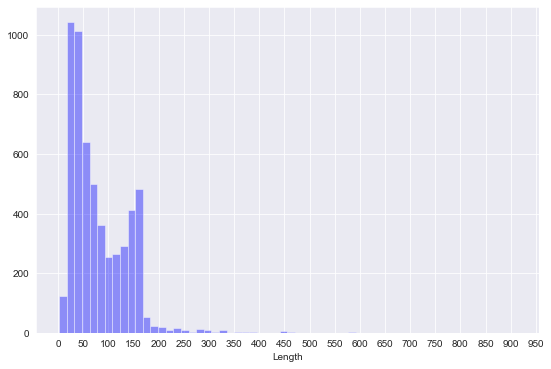

In [16]:
sns.set_style('darkgrid')
plt.figure(figsize= (9,6))
plt.xticks(np.arange(0,1000,50))
sns.distplot(messages['Length'], bins= 60, kde= False, color= 'Blue')

We can observe a **Bimodal** histogram.  
This could mean that most of the messages are of short in length while many are significantly long.

In [17]:
messages.describe()

,Length
count,5572.000000
mean,80.490309
std,59.944527
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


Here the **max** indicates the maximum length message is of 910.

In [18]:
messages.loc[messages['Length'] == 910, 'Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

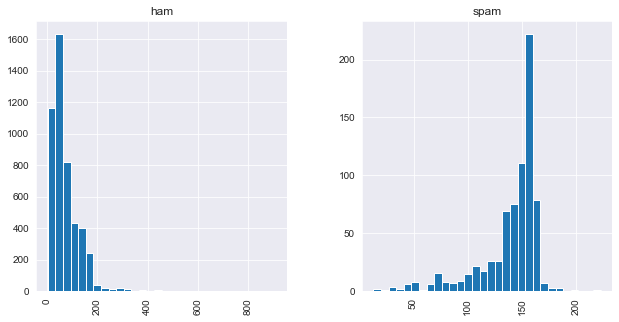

In [19]:
messages.hist(column= 'Length',by = 'Label',figsize= (10,5), bins= 30)

We can see that there's a trend of the spam messages being longer in length.

___________________________

## Text Pre-Processing

Our entire data is in textual format. However the classification require some numerical feature vector.  
We can convert a **Corpus** into a vector using **Bag Of Words** approach. In **Bag Of Words** each unique word in a vector is repesented by a number.

We'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

First we split the message into individual words and also remove the most common words like **so, in, out**.  
So we create a function that processes the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

We will remove the punctuation using the python's **string** library.

In [20]:
mess = 'Huh! An example message, with some punctuation!'

nopunc = [char for char in mess if char not in string.punctuation]

In [21]:
nopunc = ''.join(nopunc)
nopunc

'Huh An example message with some punctuation'

Removed the punctuation!

In [22]:
# nltk.download('stopwords')

In [23]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [24]:
nopunc.split()

['Huh', 'An', 'example', 'message', 'with', 'some', 'punctuation']

In [25]:
#Removing words which are common (exist in stopwords)
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [26]:
clean_mess

['Huh', 'example', 'message', 'punctuation']

Now structuring this as function to transform our dataset using it.

In [27]:
def text_process(mess):
    '''
    Removing the punctuations
    Removing the common words 
    Returning the cleaned words
    '''
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [28]:
messages.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


____________________

In [29]:
messages['Message'].iloc[2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Now we **Tokenize** theses messages. **Tokenization** is conversion of text into list of desired words only

In [30]:
#Checking our function's working
messages['Message'].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

## Continuing Normalization

There are ways to continue normalize this text.  
Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

However in our case it they are not likely to work very well due to the shorthands used by people.
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand.  
So we will just convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

It takes three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)


Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
bow_transformer = CountVectorizer(analyzer= text_process).fit(messages['Message'])

In [33]:
print(len(bow_transformer.vocabulary_))

11425


_______

Looking a sample text and its **BagOfWords**

In [34]:
message4 = messages['Message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [35]:
bow4 = bow_transformer.transform([message4])

In [36]:
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


We can see that there are seven unique words left (excluding common words) and two of the words are repeated twice.

In [37]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


/Users/prashant/Documents/workspace/repositories/simple-sms-spam-classifier/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


So we can see that the answers are obviously correct for our sample sentence.

_______

So now we can transform our entire dataframe into bag of words

In [38]:
bow_messages = bow_transformer.transform(messages['Message'])

In [39]:
print('Shape of Sparse Matrix: ',bow_messages.shape)
print('Number of Non-Zeros: ',bow_messages.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Number of Non-Zeros:  50548


In [40]:
sparsity = (100 * bow_messages.nnz)/(bow_messages.shape[0] * bow_messages.shape[1])
print('Sparsity: ',sparsity)

Sparsity:  0.07940295412668218


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### TD-IDF

**TF-IDF** stands for **term frequency-inverse document frequency**, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.  
The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.  
Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: 
- the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document  
- the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

      TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

        IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

In [42]:
tfidf_transformer = TfidfTransformer().fit(bow_messages)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We can check the IDF of some words 

In [43]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


Converting the entire Corpus

In [44]:
tfidf_messages = tfidf_transformer.transform(bow_messages)
print(tfidf_messages.shape)

(5572, 11425)


## Training a Model

After the conversion of messages into vectors, we can train our spam/ham classifier.  
We can use any clssification algorithm although for specific reasons [document here](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

In [45]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(tfidf_messages, messages["Label"])

In [46]:
#Check our model on a single prediction
print('Predicted: ',spam_detect_model.predict(tfidf4)[0])
print('Actual   : ',messages['Label'][3])

Predicted:  ham
Actual   :  ham


## Model Evaluation

In [47]:
predictions = spam_detect_model.predict(tfidf_messages)

In [48]:
print(predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [49]:
from sklearn.metrics import classification_report
cfr = classification_report(messages['Label'], predictions)
print(cfr)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



We have obtained a pretty good accuracy, however we tested on the same set as we trained so we will now rather do it using our traditional train test split approach

In [50]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(messages[['Message']], messages[['Label']], test_size = 0.25, random_state = 0)

In [51]:
print(len(msg_train), len(msg_test), len(label_train), len(label_test))

4179 1393 4179 1393


____________

## Creating Data Pipeline

Now rather than doing all of the preprocessing again on this data we can use the **Pipelining** capabilities to make it usable for future.

In [52]:
from sklearn.pipeline import Pipeline
#parameters
'''steps : list
    List of (name, transform) tuples (implementing fit/transform) that are
    chained, in the order in which they are chained, with the last object
    an estimator.'''
pipeline = Pipeline([
                    ('bow', CountVectorizer(analyzer= text_process)),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', MultinomialNB())])

In [53]:
pipeline.fit(msg_train['Message'], label_train)

/Users/prashant/Documents/workspace/repositories/simple-sms-spam-classifier/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f8302dc70d0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [59]:
predictions = pipeline.predict(msg_test['Message'])

In [60]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1208
        spam       1.00      0.75      0.86       185

    accuracy                           0.97      1393
   macro avg       0.98      0.88      0.92      1393
weighted avg       0.97      0.97      0.96      1393



We got an accuracy of around 97%

In [61]:
user_msg = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
user_msg = user_msg.rstrip()

In [62]:
type(msg_test)

pandas.core.frame.DataFrame

In [63]:
msg_test

,Message
4456,"Storming msg: Wen u lift d phne, u say ""HELLO""..."
690,<Forwarded from 448712404000>Please CALL 08712...
944,And also I've sorta blown him off a couple tim...
3768,"Sir Goodmorning, Once free call me."
1189,All will come alive.better correct any good lo...
...,...
1889,No. On the way home. So if not for the long dr...
2250,"Thanks for your ringtone order, ref number R83..."
2915,Sorry! U can not unsubscribe yet. THE MOB offe...
1282,Am I the only one who doesn't stalk profiles?


In [64]:
pipeline.predict(msg_test['Message'])

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [65]:
import joblib
joblib.dump(pipeline, "spamclassifier.dump")

['spamclassifier2.dump']

In [66]:
!pip freeze > requirements.txt

### Voila!